<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 169 (delta 25), reused 39 (delta 10), pack-reused 106
Receiving objects: 100% (169/169), 16.18 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [2]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle
import random

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 72
#Number of epochs
num_epochs = 1600
#Number of layers
num_layers = 4
#Number of neurons
num_neur=500 


In [5]:
cd Neutron_Reflect/

/content/Neutron_Reflect


In [6]:
#Stored those numpy arrays
data_path = './data/'
expt_arr = np.load(os.path.join(data_path,'mod_expt.npy'))
# expt_arr_o = np.loadtxt(os.path.join(data_path,'flipped_sorted_no_nano_expt.dat')).T
# expt_arr = np.zeros_like(expt_arr_o)
# # expt_arr[0] = 1791.5076453352374 - expt_arr_o[0]
# expt_arr[0] = expt_arr_o[0]
# expt_arr[1] = expt_arr_o[1]
sld_arr = np.load(os.path.join(data_path,'mod_sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'mod_params_fp49.npy'))
# t_sld_arr = np.load(os.path.join(data_path,'train_data.npy'))
# params_arr = np.load(os.path.join(data_path,'train_pars.npy'))

In [7]:
expt_arr.shape ,sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype, expt_arr.dtype

((2, 72),
 (5942, 2, 72),
 (5942, 3),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

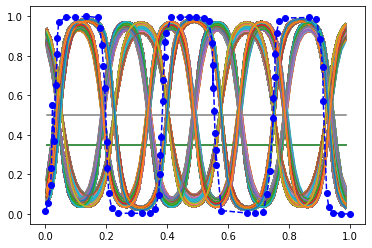

In [8]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0],sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [9]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [10]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 72) (4753, 3) (594, 2, 72) (594, 3) (595, 2, 72) (595, 3)


In [11]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [12]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [13]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  # torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [ ]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

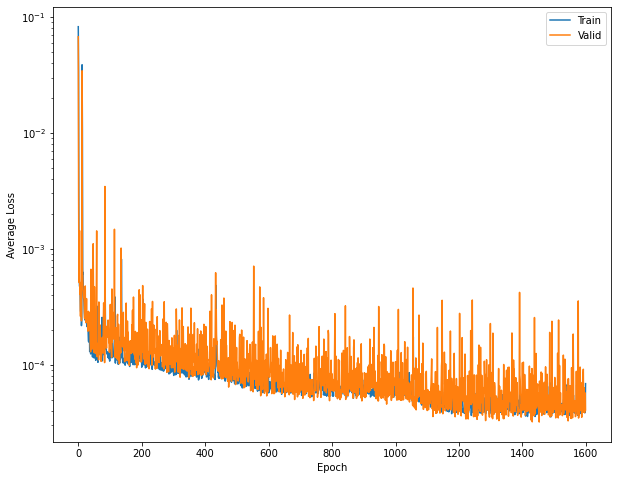

In [15]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 3.8437687180703506e-05
For image 1, the loss = 1.648367651796434e-05
For image 2, the loss = 6.743069661752088e-06
For image 3, the loss = 1.9773109670495614e-05
For image 4, the loss = 0.0002183526084991172
For image 5, the loss = 2.699531069083605e-05
For image 6, the loss = 2.6738640372059308e-05
For image 7, the loss = 3.210105205653235e-05
For image 8, the loss = 3.272884350735694e-05
For image 9, the loss = 1.0040224879048765e-05


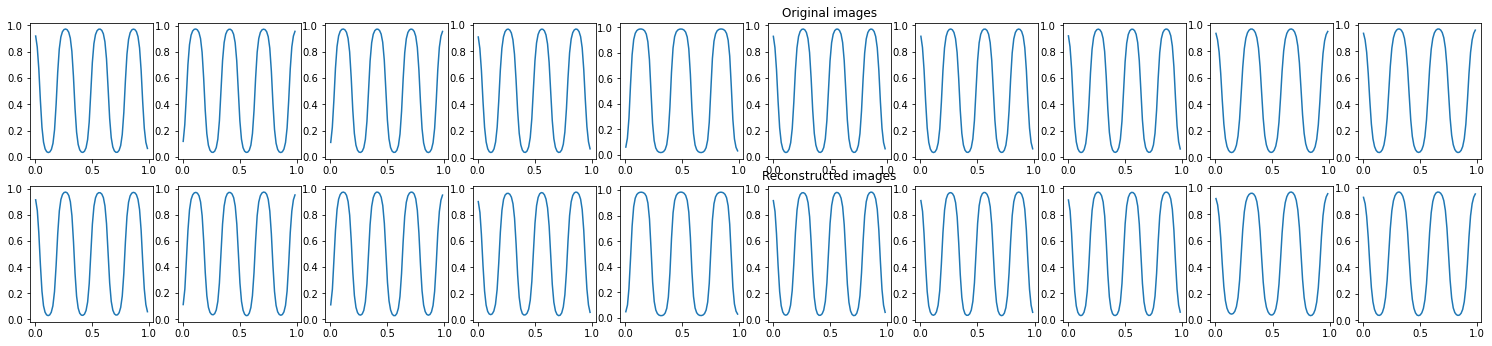

In [16]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([-9.1783e-01,  8.3801e-04, -3.6623e+00])
tensor([2.4568e+00, 1.2845e-03, 2.7286e+00])


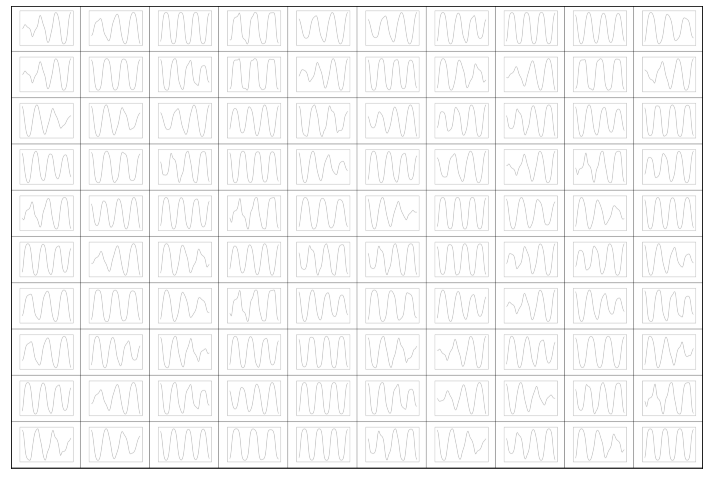

In [17]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [18]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  # print(label_index)

In [19]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,label0,label1,label2
0,-2.174518,0.002275,-7.364136,0.116,0.243,-0.45152
1,2.813875,-0.000515,-4.983515,0.169,-0.511,-0.3637
2,-1.910011,0.002036,-6.856413,0.071,0.125,-0.20281
3,-2.171421,0.002230,-7.181225,0.0998,0.504,-0.38
4,-4.481140,0.002176,-2.597126,0.196,0.134,0.30213
...,...,...,...,...,...,...
4748,-2.267856,0.002308,-7.329922,0.142,0.516,-0.56855
4749,-0.121969,-0.000308,-0.319118,0.0933,-0.152,0.35785
4750,2.835816,-0.000550,-4.879536,0.136,-0.59,-0.23227
4751,-0.149432,-0.000244,-0.536701,0.0824,-0.587,0.44883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


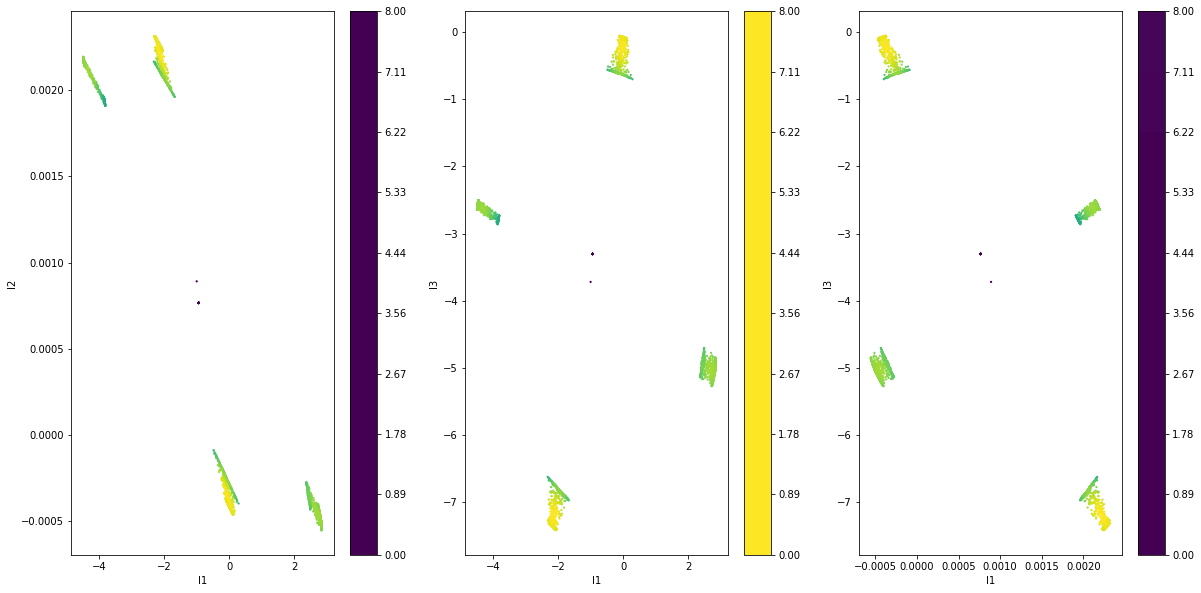

In [20]:
#Plotting the joint distributions for the latent variables

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,3,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_ylabel('l2')
ax.set_xlabel('l1')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


ax = fig.add_subplot(1,3,2)
x = df_encoded_samples['l1']
y = df_encoded_samples['l3']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_ylabel('l3')
ax.set_xlabel('l1')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


ax = fig.add_subplot(1,3,3)
x = df_encoded_samples['l2']
y = df_encoded_samples['l3']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_ylabel('l3')
ax.set_xlabel('l1')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

In [21]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 144]) torch.Size([4753, 144]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 144]) torch.Size([594, 144]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 144]) torch.Size([595, 144]) torch.Size([595, 3]) torch.Size([595, 3])


In [22]:
num_epochs = 2000
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [23]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [24]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/2000 	 train loss 0.04547188803553581 	 val loss 0.025683894753456116
EPOCH 2/2000 	 train loss 0.020853346213698387 	 val loss 0.027170788496732712
EPOCH 3/2000 	 train loss 0.021101707592606544 	 val loss 0.02041669189929962
EPOCH 4/2000 	 train loss 0.019153868779540062 	 val loss 0.020616505295038223
EPOCH 5/2000 	 train loss 0.01928004063665867 	 val loss 0.019416771829128265
EPOCH 6/2000 	 train loss 0.01924089528620243 	 val loss 0.02018989622592926
EPOCH 7/2000 	 train loss 0.01881413348019123 	 val loss 0.019517680630087852
EPOCH 8/2000 	 train loss 0.0183298010379076 	 val loss 0.019528493285179138
EPOCH 9/2000 	 train loss 0.0182491447776556 	 val loss 0.0171169713139534
EPOCH 10/2000 	 train loss 0.018111320212483406 	 val loss 0.017945798113942146
EPOCH 11/2000 	 train loss 0.0183390025049448 	 val loss 0.016761455684900284
EPOCH 12/2000 	 train loss 0.01735800690948963 	 val loss 0.017740411683917046
EPOCH 13/2000 	 train loss 0.017267649993300438 	 val loss 0.018

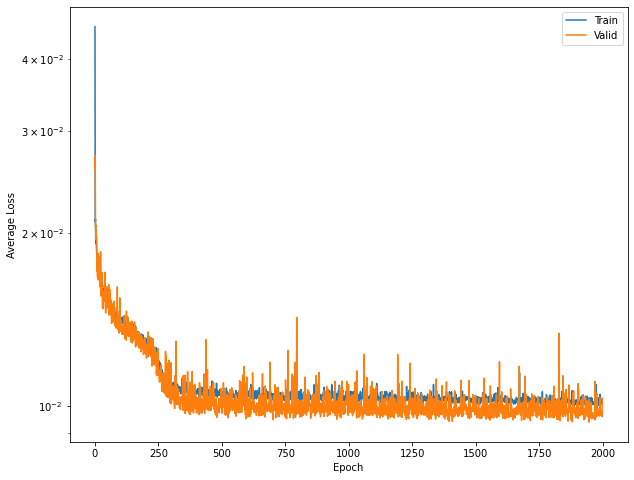

In [25]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [26]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.123608,-0.297408,-0.283039,0.0957,-0.165,-0.13252
1,0.156363,0.108641,0.486278,0.191,0.174,0.44466
2,0.068510,-0.375419,0.178969,0.0611,-0.515,0.19303
3,0.063834,0.436944,0.172565,0.0776,0.431,0.03078
4,0.116301,0.124089,-0.322183,0.0988,0.119,-0.23007
...,...,...,...,...,...,...
590,0.155336,-0.576909,-0.035934,0.182,-0.543,0.00202
591,0.155095,0.205523,0.400588,0.152,0.114,0.15448
592,0.103231,0.321329,0.284844,0.0894,0.394,0.23194
593,0.071036,-0.353284,0.384494,0.0828,-0.458,0.48203


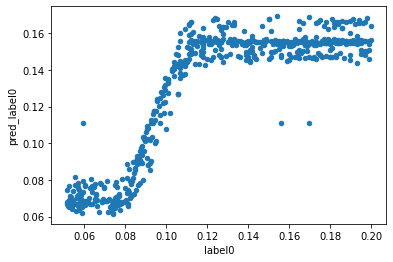

In [27]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

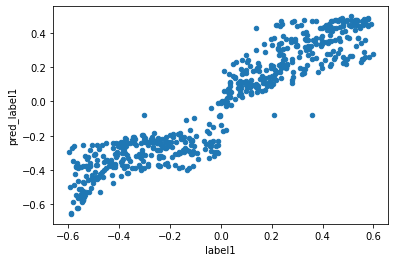

In [28]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

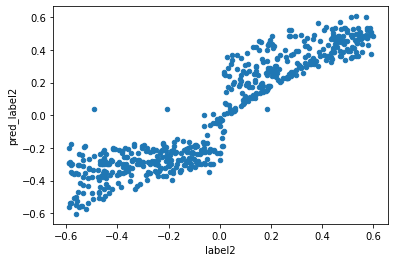

In [29]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

,l1,l2,l3,label0,label1,label2
0,1.470078,0.000287,-5.841246,0.089162,-0.176334,-0.573171


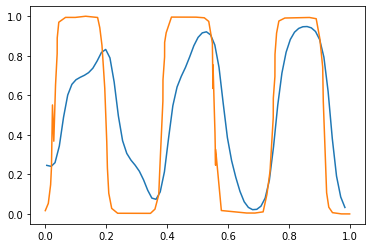

In [30]:
expt_arr_n = expt_arr[np.newaxis,:,:]
# expt_arr_n.shape

expt_labels = []

img = torch.from_numpy(expt_arr_n[0]).float()
img=torch.flatten(img).to(device)

encoder.eval().to(device)
decoder.eval().to(device)
model.eval().to(device)

with torch.no_grad():
  encoded_img  = encoder(img)
  expt_decoded_img = decoder(encoded_img)
  out_label  = model(encoder(img))

  encoded_img = encoded_img.flatten().cpu().numpy()
  out_label = out_label.cpu().numpy()

  # print(encoded_img)
  # print(out_label)
  expt_label = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}

# model.eval().to(device)
# with torch.no_grad():
#   out_label  = model(encoder(img)).cpu().numpy()

for i in range(nlabel):
    label_index = 'label'+str(i)
    expt_label[label_index] = out_label[i]

plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1])

expt_labels.append(expt_label)
df_expt_labels = pd.DataFrame(expt_labels)
df_expt_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


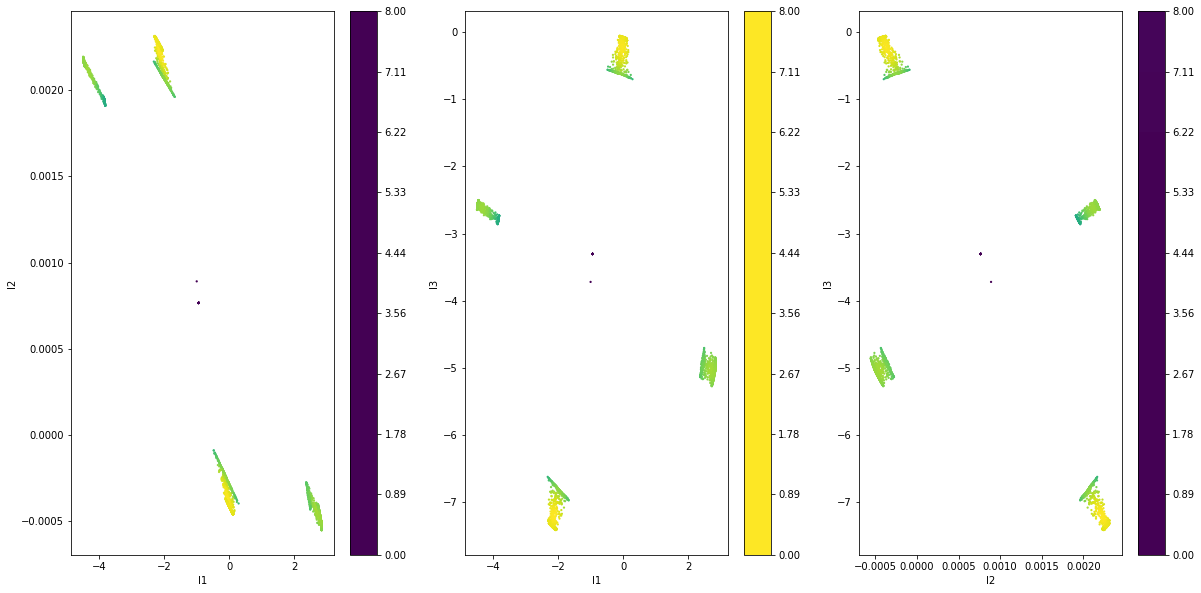

In [31]:
#Plotting the joint distributions for the latent variables for the simulated sld files
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,3,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('l1')
ax.set_ylabel('l2')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


ax = fig.add_subplot(1,3,2)
x = df_encoded_samples['l1']
y = df_encoded_samples['l3']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('l1')
ax.set_ylabel('l3')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


ax = fig.add_subplot(1,3,3)
x = df_encoded_samples['l2']
y = df_encoded_samples['l3']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('l2')
ax.set_ylabel('l3')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

,l1,l2,l3,label0,label1,label2
0,0.970078,-0.499713,-6.341246,0.101636,-0.167059,-0.586227
1,0.980179,-0.489612,-6.331145,0.101378,-0.167235,-0.585974
2,0.990280,-0.479510,-6.321043,0.101119,-0.167411,-0.585720
3,1.000381,-0.469409,-6.310943,0.100861,-0.167587,-0.585466
4,1.010482,-0.459308,-6.300842,0.100602,-0.167763,-0.585212
...,...,...,...,...,...,...
95,1.929673,0.459883,-5.381649,0.084616,-0.193973,-0.552830
96,1.939775,0.469984,-5.371549,0.084539,-0.194346,-0.552389
97,1.949875,0.480085,-5.361448,0.084462,-0.194720,-0.551948
98,1.959977,0.490186,-5.351346,0.084386,-0.195093,-0.551507


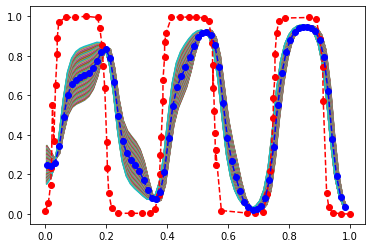

In [57]:
#Varying l1, l2 and l3 around the values above
x1 = expt_labels[0]['l1']
x2 = expt_labels[0]['l2']
x3 = expt_labels[0]['l3']
lv1_vals = np.linspace(x1-.5,x1+.5,100)
lv2_vals = np.linspace(x2-.5,x2+.5,100)
lv3_vals = np.linspace(x3-.5,x3+.5,100)
lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None], lv3_vals[:, None]), axis=-1)
lv_vals = torch.from_numpy(lv_vals).float().to(device)

#Determining the labels and the decoded images for those l1,l2,l3 above
model.eval().to(device)
with torch.no_grad():
  out_label  = model(lv_vals).cpu().numpy()
# out_label.shape

encoder.eval().to(device)
decoder.eval().to(device)

with torch.no_grad():
  decoded_img = decoder(lv_vals)

for x in range(decoded_img.shape[0]):
  plt.plot(decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[1])
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1],'ro',linestyle='dashed')
plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1],'bo',linestyle='dashed') 

deg_model = pd.DataFrame({'l1':lv_vals.cpu().numpy()[:,0],'l2':lv_vals.cpu().numpy()[:,1],'l3':lv_vals.cpu().numpy()[:,2],
                       'label0': out_label[:,0],'label1':out_label[:,1],'label2':out_label[:,2]})
deg_model

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [34]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [35]:
PATH = '/content/gdrive/MyDrive/'
torch.save(encoder.state_dict(), PATH + 'encoder.pt' )
torch.save(decoder.state_dict(), PATH + 'decoder.pt' )
torch.save(model.state_dict(), PATH + 'mlp.pt' )

In [36]:
#Reloading the encoder and decoder
encoder.load_state_dict(torch.load(PATH + 'encoder.pt'))
decoder.load_state_dict(torch.load(PATH + 'decoder.pt'))
model.load_state_dict(torch.load(PATH + 'mlp.pt'))

<All keys matched successfully>